# poi_id.py

In [1]:
# import sys
import pickle
# sys.path.append("../tools/")

# from feature_format import featureFormat, targetFeatureSplit
# from tester import dump_classifier_and_data

#### feature_format.py:

In [2]:
""" 
    A general tool for converting data from the
    dictionary format to an (n x k) python list that's 
    ready for training an sklearn algorithm
    n--no. of key-value pairs in dictonary
    k--no. of features being extracted
    dictionary keys are names of persons in dataset
    dictionary values are dictionaries, where each
        key-value pair in the dict is the name
        of a feature, and its value for that person
    In addition to converting a dictionary to a numpy 
    array, you may want to separate the labels from the
    features--this is what targetFeatureSplit is for
    so, if you want to have the poi label as the target,
    and the features you want to use are the person's
    salary and bonus, here's what you would do:
    feature_list = ["poi", "salary", "bonus"] 
    data_array = featureFormat( data_dictionary, feature_list )
    label, features = targetFeatureSplit(data_array)
    the line above (targetFeatureSplit) assumes that the
    label is the _first_ item in feature_list--very important
    that poi is listed first!
"""


import numpy as np

def featureFormat( dictionary, features, remove_NaN=True, remove_all_zeroes=True, remove_any_zeroes=False, sort_keys = False):
    """ convert dictionary to numpy array of features
        remove_NaN = True will convert "NaN" string to 0.0
        remove_all_zeroes = True will omit any data points for which
            all the features you seek are 0.0
        remove_any_zeroes = True will omit any data points for which
            any of the features you seek are 0.0
        sort_keys = True sorts keys by alphabetical order. Setting the value as
            a string opens the corresponding pickle file with a preset key
            order (this is used for Python 3 compatibility, and sort_keys
            should be left as False for the course mini-projects).
        NOTE: first feature is assumed to be 'poi' and is not checked for
            removal for zero or missing values.
    """


    return_list = []

    # Key order - first branch is for Python 3 compatibility on mini-projects,
    # second branch is for compatibility on final project.
    if isinstance(sort_keys, str):
        import pickle
        keys = pickle.load(open(sort_keys, "rb"))
    elif sort_keys:
        keys = sorted(dictionary.keys())
    else:
        keys = dictionary.keys()

    for key in keys:
        tmp_list = []
        for feature in features:
            try:
                dictionary[key][feature]
            except KeyError:
                print "error: key ", feature, " not present"
                return
            value = dictionary[key][feature]
            if value=="NaN" and remove_NaN:
                value = 0
            tmp_list.append( float(value) )

        # Logic for deciding whether or not to add the data point.
        append = True
        # exclude 'poi' class as criteria.
        if features[0] == 'poi':
            test_list = tmp_list[1:]
        else:
            test_list = tmp_list
        ### if all features are zero and you want to remove
        ### data points that are all zero, do that here
        if remove_all_zeroes:
            append = False
            for item in test_list:
                if item != 0 and item != "NaN":
                    append = True
                    break
        ### if any features for a given data point are zero
        ### and you want to remove data points with any zeroes,
        ### handle that here
        if remove_any_zeroes:
            if 0 in test_list or "NaN" in test_list:
                append = False
        ### Append the data point if flagged for addition.
        if append:
            return_list.append( np.array(tmp_list) )

    return np.array(return_list)


def targetFeatureSplit( data ):
    """ 
        given a numpy array like the one returned from
        featureFormat, separate out the first feature
        and put it into its own list (this should be the 
        quantity you want to predict)
        return targets and features as separate lists
        (sklearn can generally handle both lists and numpy arrays as 
        input formats when training/predicting)
    """

    target = []
    features = []
    for item in data:
        target.append( item[0] )
        features.append( item[1:] )

    return target, features

#### From tester.py:

In [3]:
def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)


#### Load the dictionary containing the dataset

In [4]:
with open("../ud120-projects/final_project/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

#### Total number of data points:

In [5]:
len(data_dict.keys())

146

#### Features and number of features

In [6]:
i = 0
for key in data_dict:
    if i < 1:
        print "Features:"
        all_features = data_dict[key].keys()
        print all_features
        print
        print "Number of features: ", len(all_features)
        i +=1

Features:
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']

Number of features:  21


## Task 1: Select what features you'll use.
 
features_list is a list of strings, each of which is a feature name. The first feature must be "poi". 

From above list of available features, all were included except for email_address.

In [7]:
all_features.remove('poi')

In [8]:
all_features.remove('email_address')

In [9]:
features_list = ['poi'] + all_features

In [10]:
features_list

['poi',
 'salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'from_poi_to_this_person']

In [11]:
len(features_list)

20

## Task 2: Remove outliers

In [12]:
data = featureFormat(data_dict, features_list)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

### Plotting a few features

In [14]:
def plotFeatures(data, features_list, feature_x, feature_y):
    """Plots 2 features against each other in a scatter plot.
        data - numpy array that contains the features
        feature_x - feature for x axis
        feature_y - feature that goes in the y-axis
    """
    for point in data:
        x = point[features_list.index(feature_x)]
        y = point[features_list.index(feature_y)]
        if point[0] == 1.0:
            plt.scatter(x, y, color='r', marker='*')
        else:
            plt.scatter(x, y)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.show()

*** salary vs. bonus***

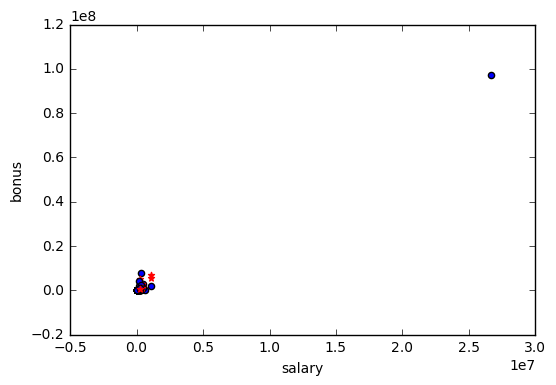

In [15]:
plotFeatures(data, features_list, 'salary', 'bonus')

Remembering from the outliers mini_project that this is the entry called "TOTAL":

In [16]:
data_dict.pop("TOTAL")

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

Examining all the other remaining keys:

In [17]:
print data_dict.keys()

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

One more key that need to be removed: 'THE TRAVEL AGENCY IN THE PARK'

In [18]:
data_dict.pop('THE TRAVEL AGENCY IN THE PARK')

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

Recreate data

In [19]:
data = featureFormat(data_dict, features_list)

*** Replotting salary vs. bonus ***

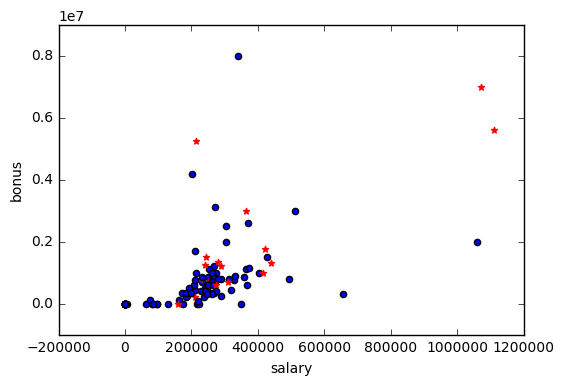

In [20]:
plotFeatures(data, features_list, 'salary', 'bonus')

Salary vs. deferral_payments

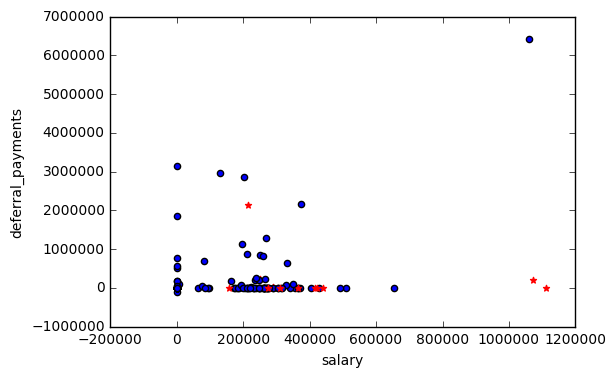

In [21]:
plotFeatures(data, features_list, 'salary', 'deferral_payments')

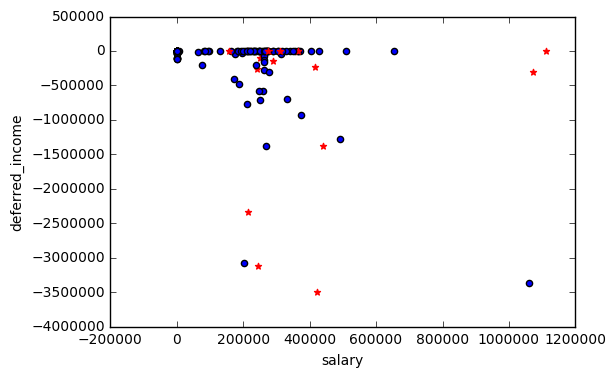

In [22]:
plotFeatures(data, features_list, 'salary', 'deferred_income')

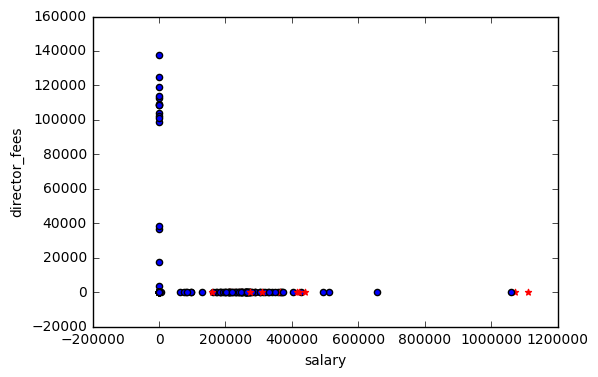

In [23]:
plotFeatures(data, features_list, 'salary', 'director_fees')

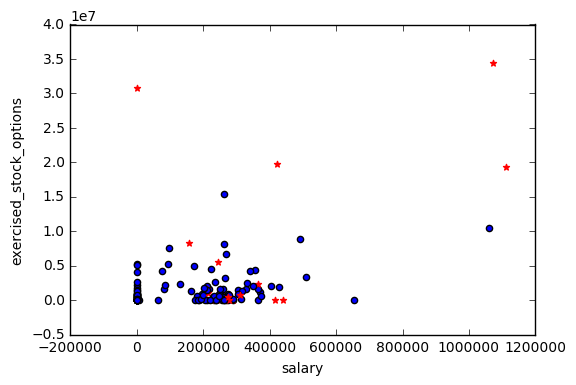

In [24]:
plotFeatures(data, features_list, 'salary', 'exercised_stock_options')

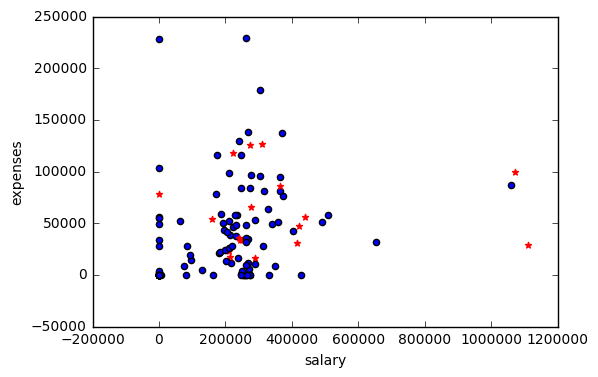

In [25]:
plotFeatures(data, features_list, 'salary', 'expenses')

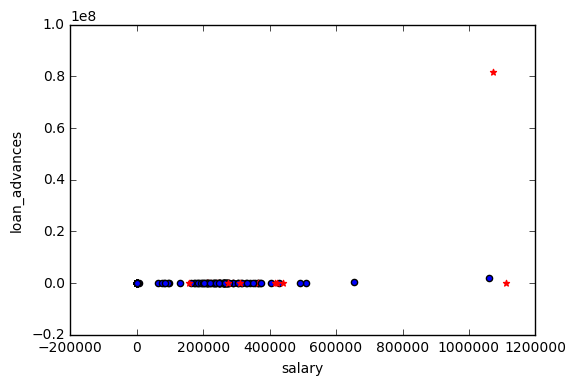

In [26]:
plotFeatures(data, features_list, 'salary', 'loan_advances')

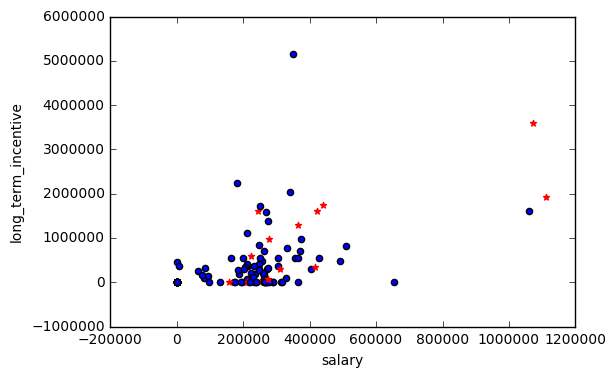

In [27]:
plotFeatures(data, features_list, 'salary', 'long_term_incentive')

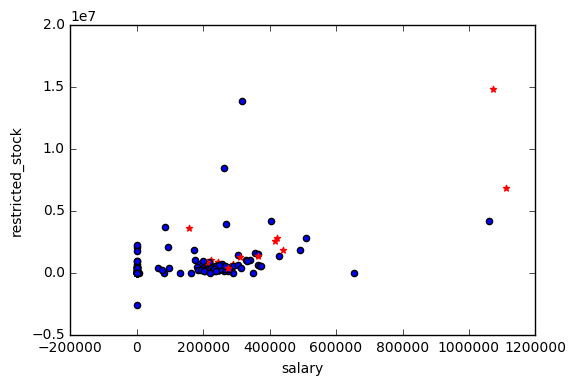

In [28]:
plotFeatures(data, features_list, 'salary', 'restricted_stock')

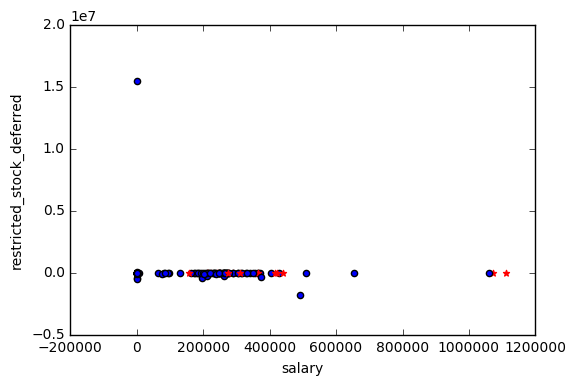

In [29]:
plotFeatures(data, features_list, 'salary', 'restricted_stock_deferred')

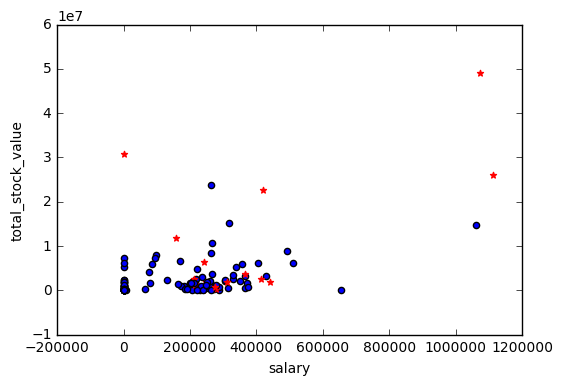

In [30]:
plotFeatures(data, features_list, 'salary', 'total_stock_value')

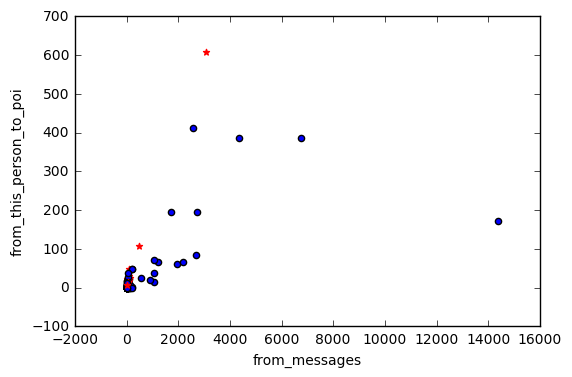

In [31]:
plotFeatures(data, features_list, 'from_messages', 'from_this_person_to_poi')

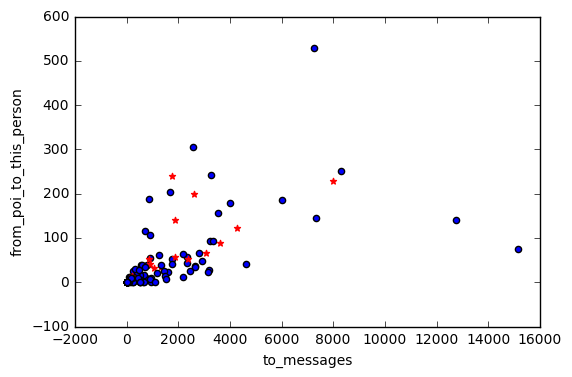

In [32]:
plotFeatures(data, features_list, 'to_messages', 'from_poi_to_this_person')

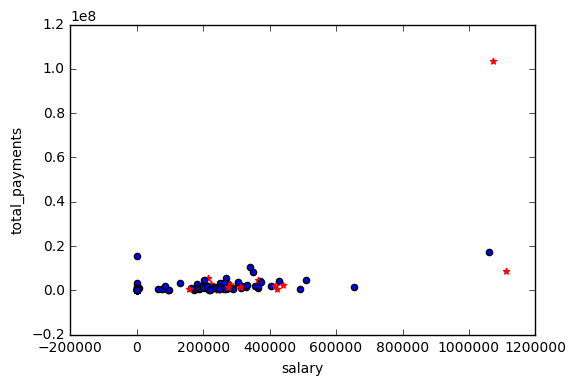

In [33]:
plotFeatures(data, features_list, 'salary', 'total_payments')

##### Using histograms

In [34]:
poi = []
non_poi = []
for point in data:
    if point[0]==1.0:
        poi.append(point)
    else:
        non_poi.append(point)

In [35]:
len(poi)

18

In [36]:
len(non_poi)

125

In [37]:
poi = np.array(poi)
non_poi = np.array(non_poi)

Some exploratory data analysis (code adapted from Introduction to Machine Learning with Python by  Andreas C. Müller and Sarah Guido)

In [38]:
len(features_list)

20

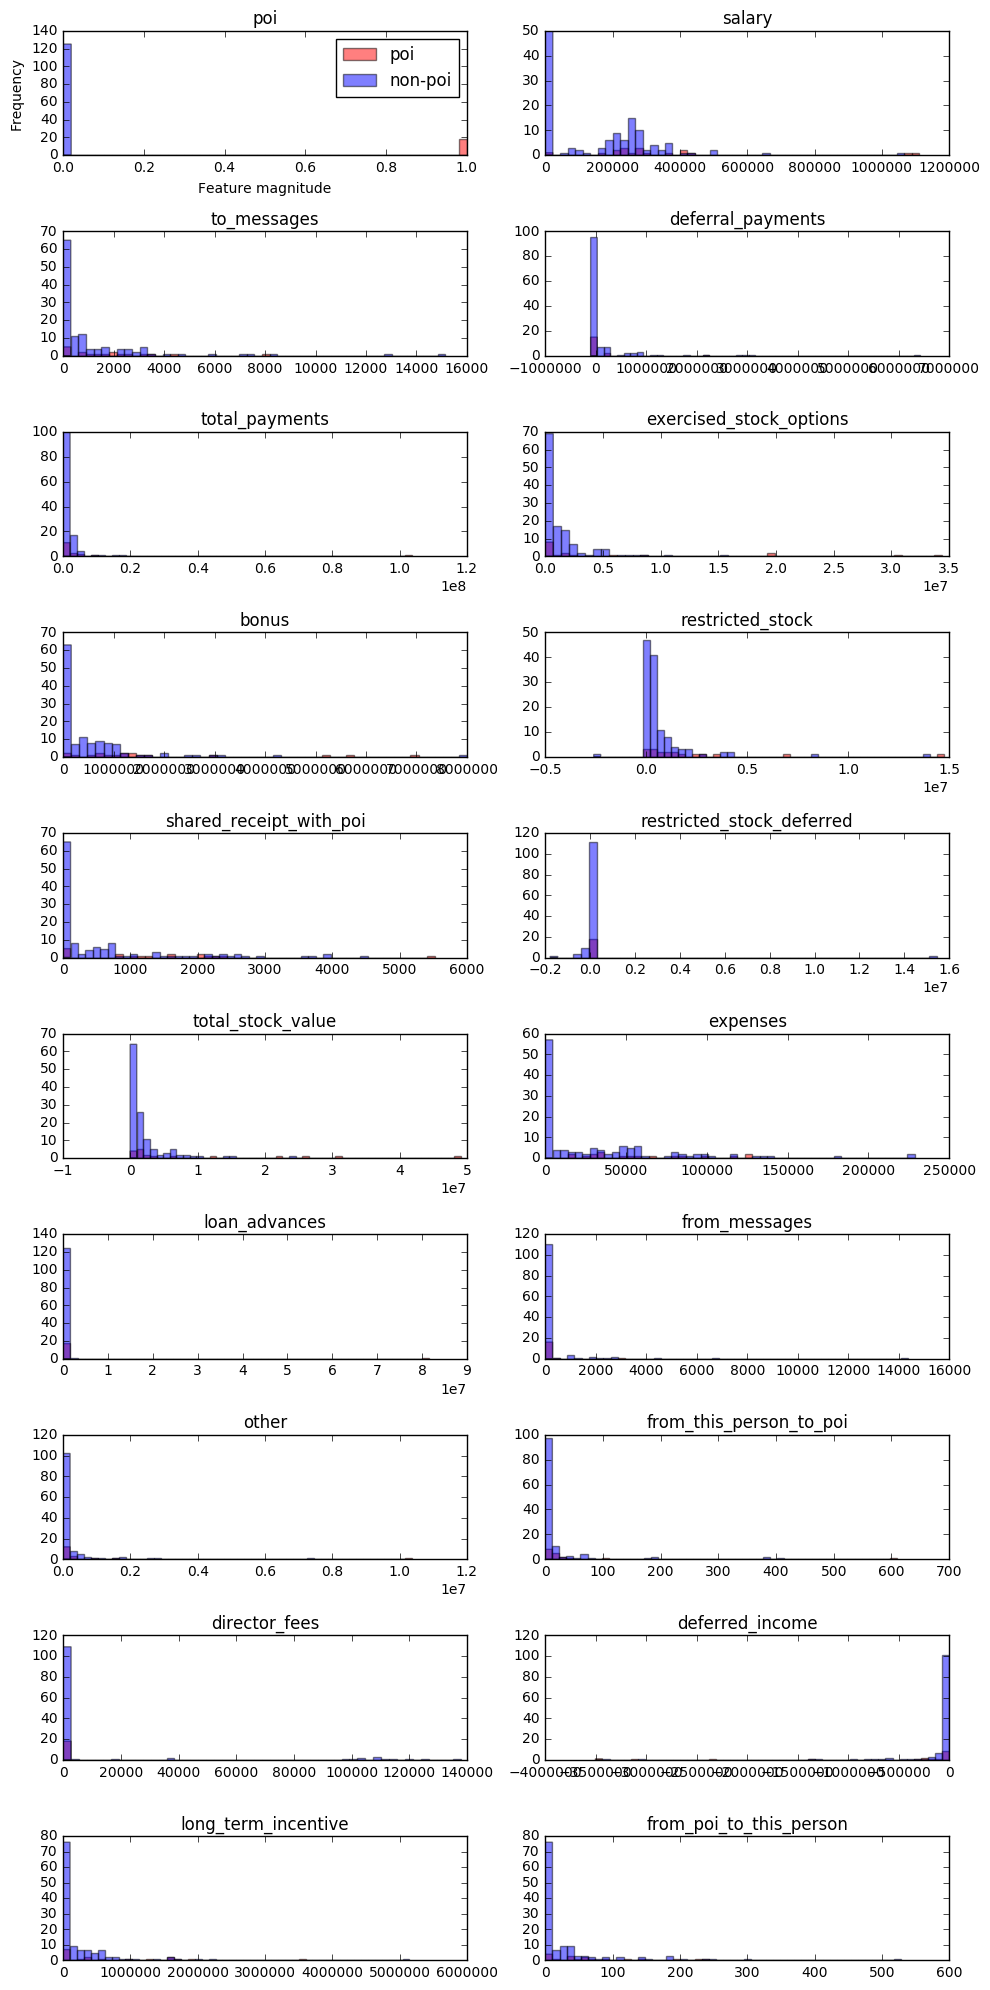

In [39]:
fig, axes = plt.subplots(10, 2, figsize=(10,20))
ax = axes.ravel()
for i, _ in enumerate(features_list):
    _, bins = np.histogram(data[:, i], bins=50)
    ax[i].hist(poi[:, i], bins=bins, color='r', alpha=0.5)
    ax[i].hist(non_poi[:, i], bins=bins, color='b', alpha=0.5)
    ax[i].set_title(features_list[i])
    #ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["poi", "non-poi"], loc="best")
fig.tight_layout()

Set y-axis limit to 15 only to see the plots more:

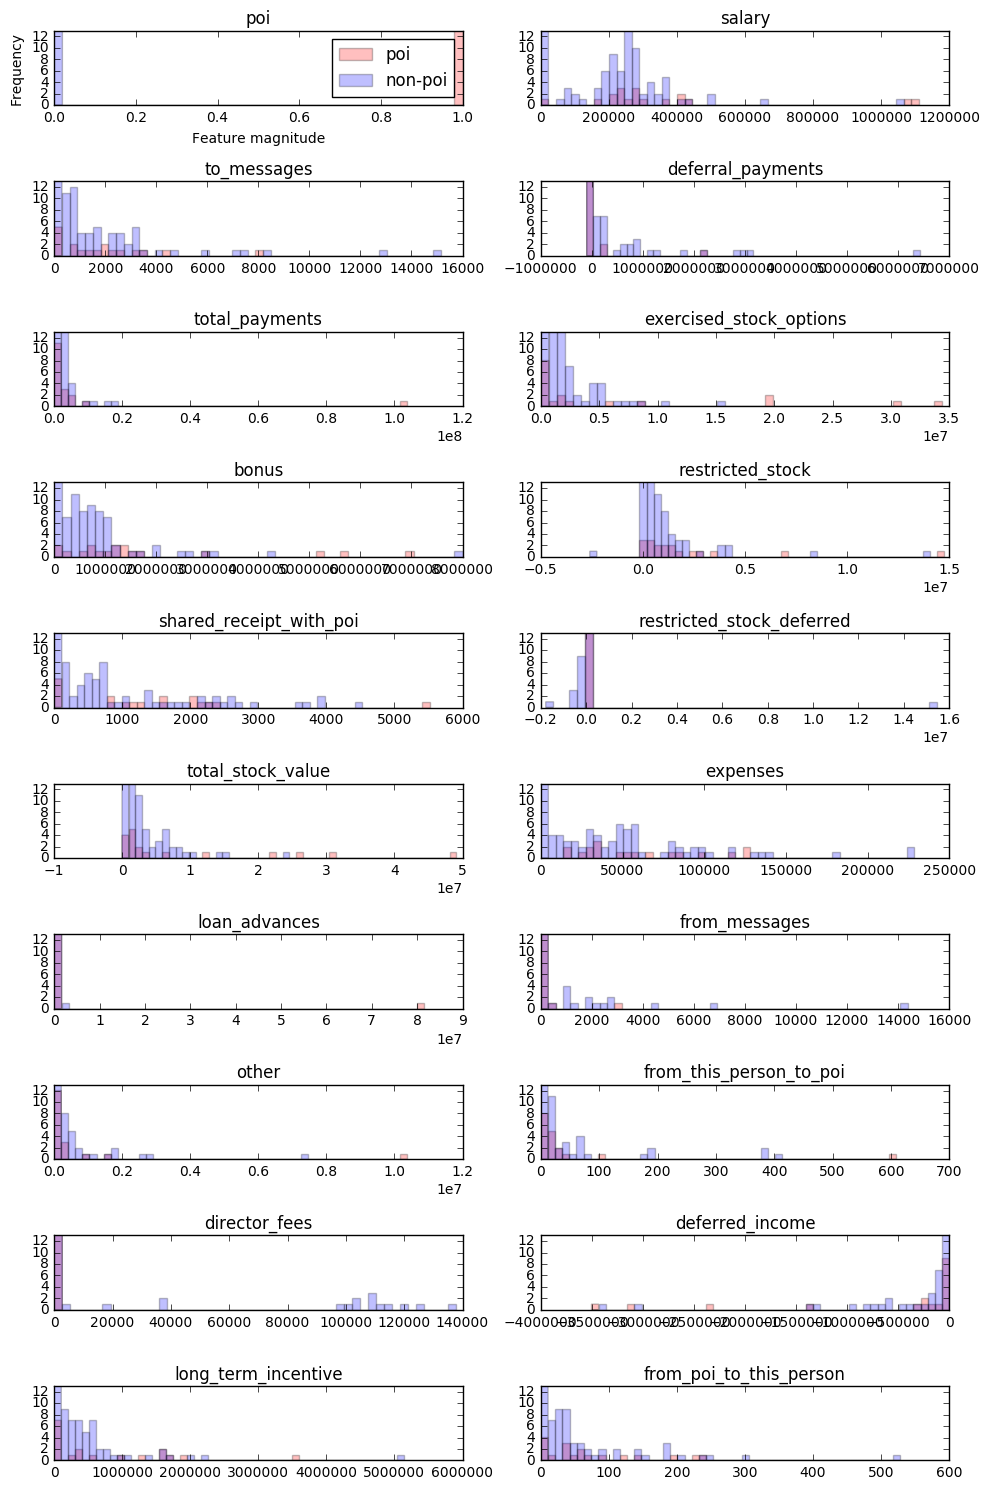

In [40]:
fig, axes = plt.subplots(10, 2, figsize=(10,15))
ax = axes.ravel()
for i, _ in enumerate(features_list):
    _, bins = np.histogram(data[:, i], bins=50)
    ax[i].hist(poi[:, i], bins=bins, color='r', alpha=0.25)
    ax[i].hist(non_poi[:, i], bins=bins, color='b', alpha=0.25)
    ax[i].set_title(features_list[i])
    ax[i].set_ylim([0,13])
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["poi", "non-poi"], loc="best")
fig.tight_layout()

The histograms do not show separation between poi and non-poi's but at least some have more variation than others. Based on this, I would like to EXCLUDE the following available features due to lack of variation on the features.

1. restricted stock deferred
2. loan advances
3. director fees
4. deferral payments
5. total payments
6. other

## Task 3: Create new feature(s)

In [41]:
def computeFraction(poi_messages, all_messages):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
    """
    if poi_messages != 'NaN' or all_messages != 'NaN':
        fraction = float(poi_messages) / float(all_messages)
    else:
        fraction = 0
    return fraction

In [42]:
for name in data_dict:
    data_point = data_dict[name]
    
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction(from_poi_to_this_person, to_messages)
    
    data_point["fraction_from_poi"] = fraction_from_poi
    
    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    
    data_point["fraction_to_poi"] = fraction_to_poi

Checking whether the new features were added:

In [43]:
c = 0
for key in data_dict:
    if c < 1:
        for feature in data_dict[key]:
            print feature
        c += 1

to_messages
deferral_payments
expenses
poi
deferred_income
email_address
long_term_incentive
fraction_from_poi
restricted_stock_deferred
shared_receipt_with_poi
loan_advances
from_messages
other
director_fees
bonus
total_stock_value
from_poi_to_this_person
from_this_person_to_poi
restricted_stock
salary
total_payments
fraction_to_poi
exercised_stock_options


Creating new numpy array:

In [44]:
all_features = []

In [45]:
c = 0
for key in data_dict:
    if c < 1:
        for feature in data_dict[key]:
            all_features.append(feature)
        c += 1

In [46]:
all_features

['to_messages',
 'deferral_payments',
 'expenses',
 'poi',
 'deferred_income',
 'email_address',
 'long_term_incentive',
 'fraction_from_poi',
 'restricted_stock_deferred',
 'shared_receipt_with_poi',
 'loan_advances',
 'from_messages',
 'other',
 'director_fees',
 'bonus',
 'total_stock_value',
 'from_poi_to_this_person',
 'from_this_person_to_poi',
 'restricted_stock',
 'salary',
 'total_payments',
 'fraction_to_poi',
 'exercised_stock_options']

Based on the histograms above, some features are removed. "poi" and "email_address" are removed, too. "poi" will be added as first in the list and "email_address" can't be converted to a float and it is not seen as a factor for poi-non-poi identification.

I also remove some of the email information as the derived info or new features calculated above will be sufficient.

In [47]:
all_features.remove('poi')
all_features.remove('email_address')
all_features.remove('restricted_stock_deferred')
all_features.remove('loan_advances')
all_features.remove('director_fees')
all_features.remove('deferral_payments')
all_features.remove('total_payments')
all_features.remove('other')
all_features.remove("from_poi_to_this_person")
all_features.remove('to_messages')
all_features.remove('from_this_person_to_poi')
all_features.remove('from_messages')

Redoing the histogram:

In [48]:
all_features

['expenses',
 'deferred_income',
 'long_term_incentive',
 'fraction_from_poi',
 'shared_receipt_with_poi',
 'bonus',
 'total_stock_value',
 'restricted_stock',
 'salary',
 'fraction_to_poi',
 'exercised_stock_options']

In [49]:
len(all_features)

11

In [50]:
features_list = ['poi'] + all_features

In [51]:
features_list

['poi',
 'expenses',
 'deferred_income',
 'long_term_incentive',
 'fraction_from_poi',
 'shared_receipt_with_poi',
 'bonus',
 'total_stock_value',
 'restricted_stock',
 'salary',
 'fraction_to_poi',
 'exercised_stock_options']

In [53]:
len(features_list)

12

In [54]:
data = featureFormat(data_dict, features_list)

In [55]:
poi = []
non_poi = []
for point in data:
    if point[0]==1.0:
        poi.append(point)
    else:
        non_poi.append(point)

In [56]:
len(poi)

18

In [57]:
len(non_poi)

123

In [58]:
poi = np.array(poi)
non_poi = np.array(non_poi)

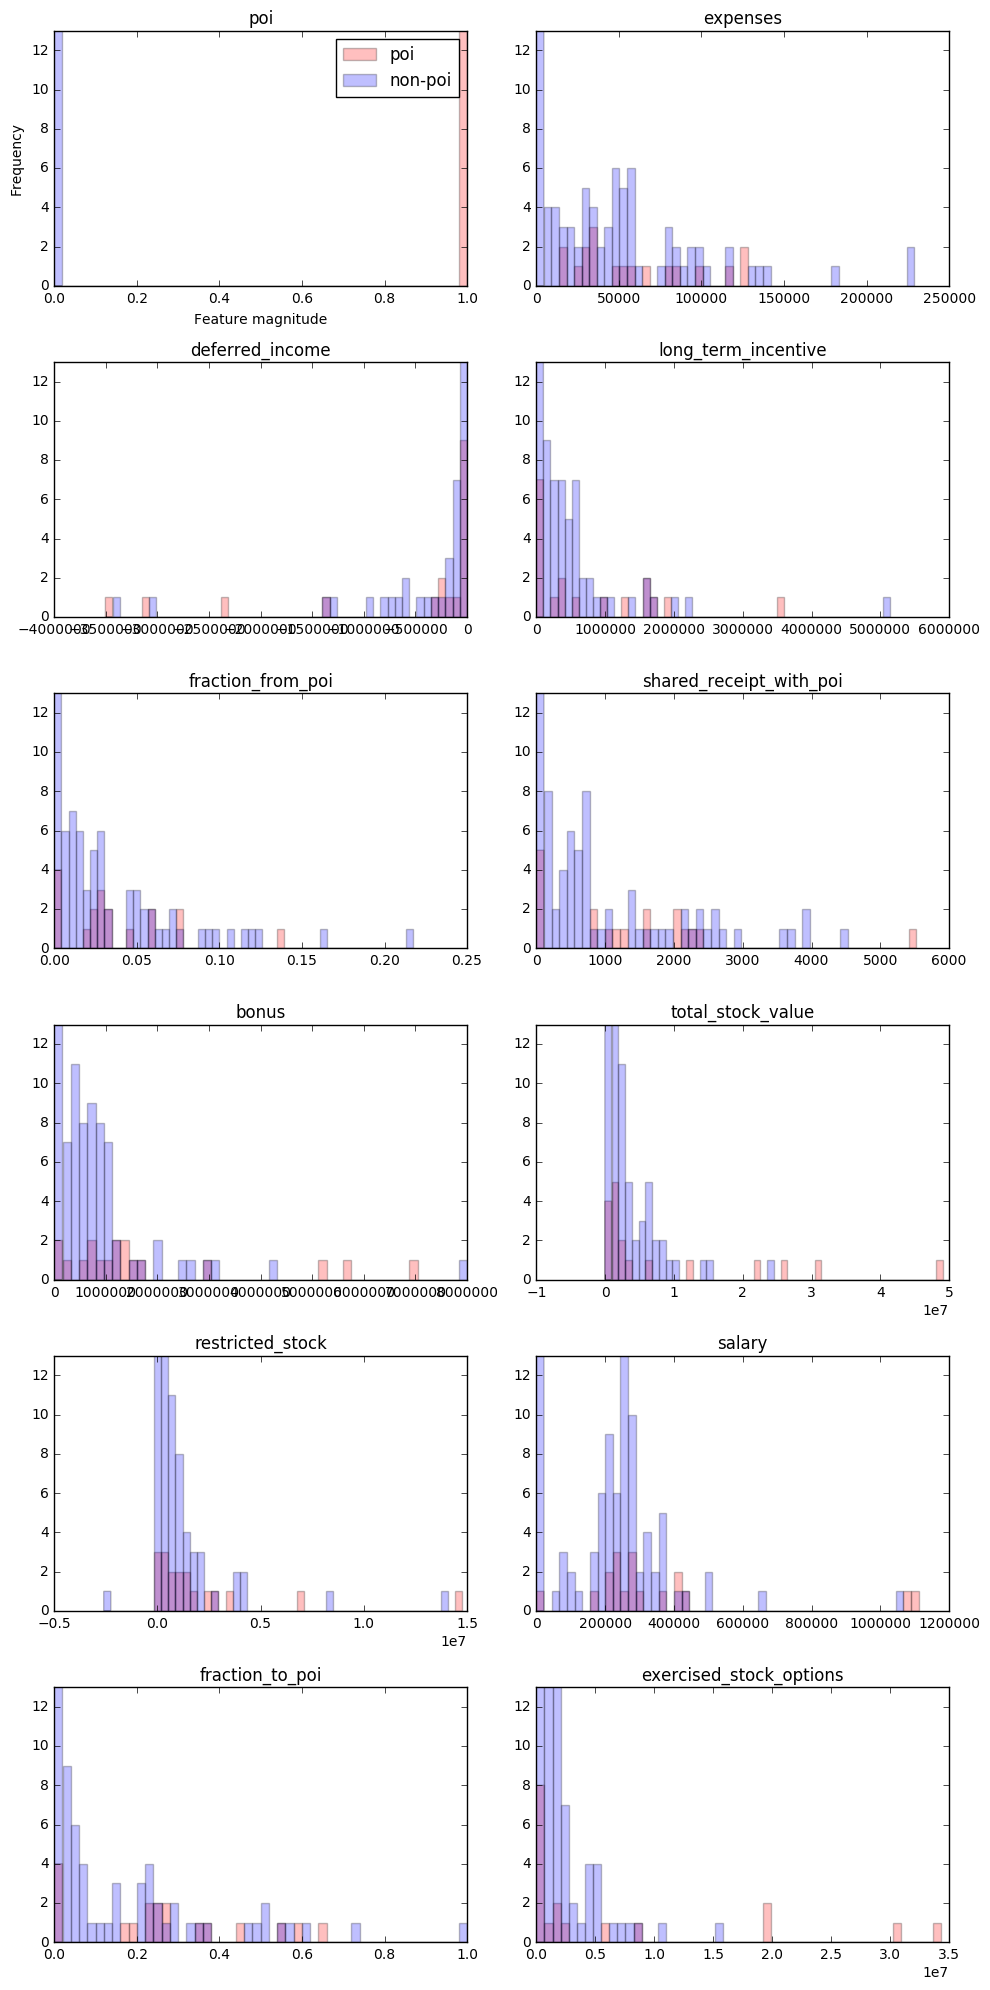

In [59]:
fig, axes = plt.subplots(6, 2, figsize=(10,20))
ax = axes.ravel()
for i, _ in enumerate(features_list):
    _, bins = np.histogram(data[:, i], bins=50)
    ax[i].hist(poi[:, i], bins=bins, color='r', alpha=0.25)
    ax[i].hist(non_poi[:, i], bins=bins, color='b', alpha=0.25)
    ax[i].set_title(features_list[i])
    ax[i].set_ylim([0,13])
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["poi", "non-poi"], loc="best")
fig.tight_layout()

#### Store data_dict to my_dataset for easy export

In [77]:
my_dataset = data_dict

#### Extract features and labes from dataset for local testing

In [78]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

#### Task 4: Try a variety of classifiers

Please name your classifier clf for easy export below. Note that if you want to do PCA or other multi-stage operations, you'll need to used Pipelines. For more info: http://scikit-learn.org/stable/modules/pipeline.html

```
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
```

#### Splitting the features to test and train

In [79]:
from sklearn import model_selection

In [80]:
features_train, features_test, labels_train, labels_test = model_selection.train_test_split(features, labels, test_size=0.3, random_state=42)

In [81]:
features_train = np.array(features_train)

In [82]:
features_train.min(axis=0)

array([       0., -3367011.,        0.,        0.,        0.,        0.,
              0.,   -44093.,        0.,        0.,        0.,        0.,
              0.])

In [83]:
features_train.max(axis=0)

array([  2.28763000e+05,   0.00000000e+00,   5.14543400e+06,
         2.17341040e-01,   5.52100000e+03,   1.03597290e+07,
         7.00000000e+06,   4.91100780e+07,   1.47616940e+07,
         1.11125800e+06,   1.03559793e+08,   1.00000000e+00,
         3.43483840e+07])

### Scaling

In [84]:
from sklearn.preprocessing import MinMaxScaler

In [85]:
scaler = MinMaxScaler()

In [86]:
features_train_scaled = scaler.fit_transform(features_train)

In [87]:
features_train_scaled.min(axis=0)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [88]:
features_train_scaled.max(axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [89]:
features_test = np.array(features_test)

In [90]:
features_test_scaled = scaler.transform(features_test)

In [91]:
features_test_scaled.min(axis=0)

array([ 0.        , -0.04080028,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.00089703, -0.17643571,  0.        ,
        0.        ,  0.        ,  0.        ])

In [92]:
features_test_scaled.max(axis=0)

array([ 0.56452311,  1.        ,  0.39557013,  0.62813158,  0.71762362,
        0.15186922,  1.14285714,  0.62680656,  0.27988617,  0.37852236,
        0.14924991,  0.72      ,  0.8957063 ])

Converting labels test and labels train to numpy arrays

In [93]:
labels_test = np.array(labels_test)

In [94]:
labels_train = np.array(labels_train)

#### PCA on rescaled values

In [95]:
from sklearn.decomposition import PCA

In [96]:
pca = PCA(n_components=3)

In [97]:
pca.fit(features_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [98]:
first_pc = pca.components_[0]
second_pc = pca.components_[1]

In [99]:
first_pc

array([ 0.22428826, -0.19482869,  0.23300591,  0.13065229,  0.33905519,
        0.24763524,  0.37673615,  0.26804902,  0.28177838,  0.4589852 ,
        0.19687026,  0.22854672,  0.26316301])

In [100]:
second_pc

array([ -2.51138262e-01,   7.95895440e-02,   1.52715177e-01,
        -4.91645248e-01,  -3.78649330e-01,   2.21583997e-01,
        -2.97336451e-04,   2.84156250e-01,   3.33050087e-01,
         3.39772191e-03,   1.61396234e-01,  -4.31244213e-01,
         2.63408879e-01])

In [101]:
pca.explained_variance_ratio_

array([ 0.40313939,  0.15951871,  0.12020783])

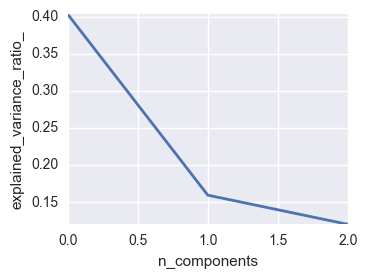

In [102]:
plt.figure(1, figsize=(4,3))
plt.clf()
plt.axes([.2,.2,.7,.7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.show()

In [103]:
features_train_pca = pca.transform(features_train_scaled)

In [104]:
features_test_pca = pca.transform(features_test_scaled)

### SVM

In [125]:
param_grid = {'C': [1, 10, 50, 100],
          'gamma': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 5e-4],
          'kernel': ['rbf', 'linear']}

In [126]:
from sklearn.svm import SVC

In [127]:
from sklearn.model_selection import GridSearchCV

In [128]:
clf = GridSearchCV(SVC(), param_grid)

In [129]:
clf = clf.fit(features_train_pca, labels_train)

In [130]:
clf.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1e-08, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [131]:
round(clf.score(features_test_pca, labels_test), 4)

0.8837

In [132]:
from sklearn.metrics import confusion_matrix

In [133]:
pred = clf.predict(features_test_pca)

In [134]:
confusion_matrix(labels_test, pred)

array([[38,  0],
       [ 5,  0]])

In [135]:
from collections import Counter

In [136]:
Counter(labels_test)

Counter({0.0: 38, 1.0: 5})

### Naive Bayes

In [137]:
from sklearn.naive_bayes import GaussianNB

In [138]:
clfnb = GaussianNB()

In [139]:
clfnb.fit(features_train_pca, labels_train)

GaussianNB(priors=None)

In [140]:
round(clfnb.score(features_test_pca, labels_test), 4)

0.8837

In [141]:
pred = clfnb.predict(features_test_pca)

In [142]:
confusion_matrix(labels_test, pred)

array([[37,  1],
       [ 4,  1]])

### KNN

In [157]:
from sklearn.neighbors import KNeighborsClassifier

In [158]:
clfKNN = KNeighborsClassifier(n_neighbors=3)

In [159]:
clfKNN.fit(features_train_pca, labels_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [160]:
round(clfKNN.score(features_test_pca, labels_test), 4)

0.8837

In [161]:
pred = clfKNN.predict(features_test_pca)

In [162]:
confusion_matrix(labels_test, pred)

array([[38,  0],
       [ 5,  0]])

### Decision Trees

In [163]:
from sklearn.tree import DecisionTreeClassifier

In [164]:
clftree = DecisionTreeClassifier(min_samples_split=2)

In [165]:
clftree.fit(features_train_pca, labels_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [166]:
round(clftree.score(features_test_pca, labels_test), 4)

0.8837

In [167]:
pred = clftree.predict(features_test_pca)

In [168]:
confusion_matrix(labels_test, pred)

array([[36,  2],
       [ 3,  2]])

In [169]:
from sklearn.metrics import recall_score, precision_score

In [172]:
recall_score(labels_test, pred)

0.40000000000000002

In [173]:
precision_score(labels_test, pred)

0.5

### Neural Networks

In [149]:
from sklearn.neural_network import MLPClassifier

In [150]:
clfNN = MLPClassifier()

In [151]:
clfNN.fit(features_train_scaled, labels_train)

/Users/alonavarshal/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [152]:
clfNN.score(features_test_scaled, labels_test)

0.86046511627906974

In [155]:
pred = clfNN.predict(features_test_scaled)

### Evaluation Metrics

In [156]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels_test, pred )

array([[36,  2],
       [ 4,  1]])

### Results from un-rescaled data

DecisionTree classification

In [55]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(features_train, labels_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [56]:
clf.score(features_test, labels_test)

0.79069767441860461

<- after removal of outlier. compare to validation_miniproject.ipynb results

http://localhost:8888/notebooks/DataScience/udacity/dand/intro_to_machine_learning/13_Validation/validation_miniproject.ipynb

Value obtained was 0.724

How about if we do PCA first?

In [57]:
from sklearn.decomposition import PCA

In [58]:
pca = PCA()

In [59]:
pca.fit(features_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

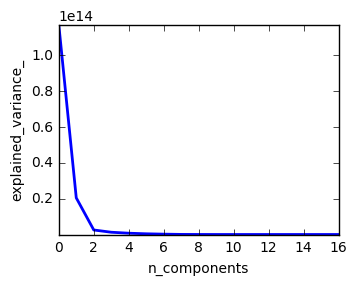

In [62]:
plt.figure(1, figsize=(4,3))
#plt.clf()
plt.axes([.2,.2,.7,.7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

In [65]:
first_pc = pca.components_[0]

In [66]:
first_pc

array([  1.17266684e-02,   7.24073630e-02,   6.19889346e-03,
        -1.19651873e-02,  -2.62286337e-04,   4.02671061e-01,
         7.02612130e-04,  -4.63153532e-06,   1.08812002e-06,
        -2.81569885e-08,   6.90290387e-01,   3.65266806e-02,
         1.68715404e-01,  -4.55144355e-04,   2.05681106e-05,
         3.20265148e-05,   5.70958324e-01])

In [67]:
second_pc = pca.components_[1]
second_pc

array([  1.41963030e-02,   4.35395141e-02,   2.86480472e-02,
        -5.80952563e-02,  -8.97282585e-04,   3.97033741e-01,
         1.74775029e-04,  -7.99619831e-06,   1.17102686e-06,
         1.10976847e-07,  -7.22099990e-01,   1.93369029e-02,
         1.48584027e-01,  -5.19043238e-03,   1.52690503e-05,
         3.35920195e-06,   5.40521890e-01])

In [68]:
pca.explained_variance_ratio_

array([  8.20628010e-01,   1.43210037e-01,   1.76504965e-02,
         8.84570001e-03,   5.03949599e-03,   2.75445174e-03,
         1.36596095e-03,   3.62065293e-04,   1.26348000e-04,
         1.17707920e-05,   5.47841198e-06,   1.44095079e-07,
         2.78187511e-08,   1.23821155e-08,   8.03112073e-10,
         1.58146744e-11,   7.05811412e-12])

Following steps in

http://localhost:8888/notebooks/DataScience/udacity/dand/intro_to_machine_learning/13_Validation/cross_validation_testing.ipynb

In [70]:
pcatransformed_features_train = pca.transform(features_train)

In [71]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(pcatransformed_features_train, labels_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [72]:
pcatransformed_features_test = pca.transform(features_test)

In [73]:
pred = clf.predict(pcatransformed_features_test)

In [74]:
np.mean(pred == labels_test)

0.83720930232558144

Try Naive Bayes:

In [87]:
from sklearn.naive_bayes import GaussianNB

In [89]:
clf1 = GaussianNB()

In [90]:
clf1.fit(pcatransformed_features_train, labels_train)

GaussianNB(priors=None)

In [91]:
pred = clf1.predict(pcatransformed_features_test)

In [92]:
accuracy_score(pred, labels_test)

0.83720930232558144

SVM

In [80]:
from sklearn.svm import SVC
clf = SVC()

In [81]:
clf.fit(pcatransformed_features_train, labels_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [82]:
pred = clf.predict(pcatransformed_features_test)

In [84]:
from sklearn.metrics import accuracy_score

In [86]:
accuracy_score(pred, labels_test)

0.83720930232558144

Evaluation

In [95]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels_test, pred)

array([[34,  2],
       [ 5,  2]])

In [97]:
from collections import Counter
Counter(labels_test)

Counter({0.0: 36, 1.0: 7})

In [98]:
from sklearn.metrics import recall_score, precision_score

In [99]:
recall_score(labels_test, pred)

0.2857142857142857

In [100]:
precision_score(labels_test, pred)

0.5

In [ ]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)